## Install required packages.

Uses a pip command to install libraries such as minisom, scanpy, tensorflow, matplotlib, seaborn, igraph, leidenalg, and louvain.

In [1]:
!pip install minisom scanpy tensorflow matplotlib seaborn igraph leidenalg louvain


In [2]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from minisom import MiniSom
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

2025-05-18 15:58:01.467002: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 15:58:01.471155: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 15:58:01.544852: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 15:58:01.649415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747562281.767964 2744756 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747562281.80

## Load and preprocess the single-cell dataset.


- Loads the PBMC3k dataset from Scanpy.
- Filters cells with a minimum number of genes and genes with a minimum number of cells.
- Normalizes, log-transforms, and selects highly variable genes (top 2000).
- Prints dataset dimensions and performs exploratory analysis (plotting highest expressed genes and PCA variance ratio).
- Scales the data using StandardScaler.

Preprocessed dataset: 2700 cells, 2000 genes


/home/saif/miniconda3/envs/py12/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


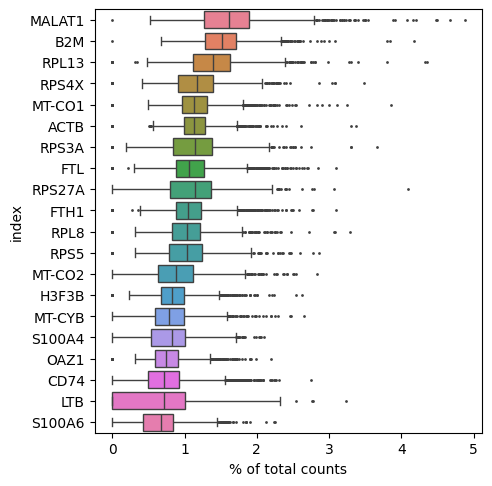

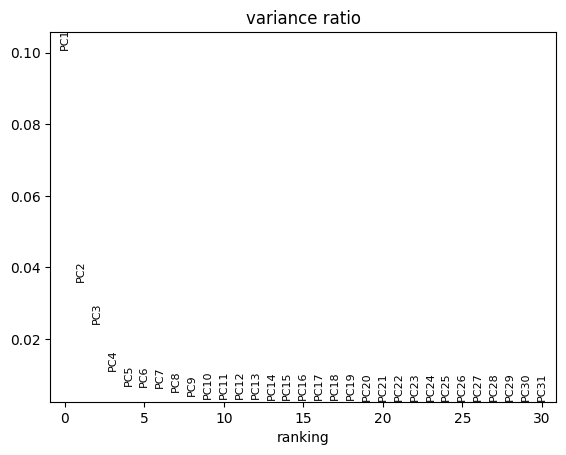

In [3]:
# Load and preprocess data
adata = sc.datasets.pbmc3k()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

print(f"Preprocessed dataset: {adata.shape[0]} cells, {adata.shape[1]} genes")

# Exploratory analysis
sc.pl.highest_expr_genes(adata, n_top=20, save='_top_genes.png')
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, save='_pca_variance.png')

# Scale data
X = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
X = StandardScaler().fit_transform(X)

# Build the autoencoder and encoder models.


- Defines the autoencoder architecture using Keras functional API.
- Uses a dense layer with ReLU and regularization, applies batch normalization and dropout, and creates an encoded representation (without an activation function to suit the SOM later).
- Constructs the decoder part with a linear activation for output reconstruction.
- Compiles the autoencoder using the Adam optimizer and mean squared error (mse) loss.
- Prints the model summary and counts total trainable parameters.

In [4]:
# Build Autoencoder
input_dim = X.shape[1]
encoding_dim = 64

input_layer = Input(shape=(input_dim,))
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-5))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
encoded = Dense(encoding_dim)(x)  # No ReLU for SOM
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-5))(encoded)
decoded = Dense(input_dim, activation='linear', kernel_regularizer=l2(1e-5))(x)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer=Adam(1e-3), loss='mse')
autoencoder.summary()

# Parameter counting
print(f"Total trainable parameters: {autoencoder.count_params()}")

2025-05-18 15:58:06.949560: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,024,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2000)           │     1,026,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,118,672 (8.08 MB)

 Trainable params: 2,117,648 (8.08 MB)

 Non-trainable params: 1,024 (4.00 KB)

Total trainable parameters: 2118672


# Train the autoencoder.

- Sets up early stopping to monitor the validation loss with a patience of 10 epochs and restore the best weights.
- Fits the autoencoder on the scaled data (with validation split).
- Plots and saves the training and validation loss curves.

In [5]:
# Train Autoencoder
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = autoencoder.fit(
    X, X,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Plot training/validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_loss.png')
plt.close()

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0548 - val_loss: 0.9935
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9790 - val_loss: 0.9774
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9622 - val_loss: 0.9681
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9248 - val_loss: 0.9688
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8975 - val_loss: 0.9641
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8866 - val_loss: 0.9638
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8837 - val_loss: 0.9628
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8705 - val_loss: 0.9628
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8645 - val_loss: 0.9866
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8429 - val_loss: 0.9698
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8369 - val_loss: 0.9684
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8210 - v

# Encode the data using the encoder.


- Uses the trained encoder to generate the latent (compressed) space representations of the input data.
- Stores the latent representations inside the AnnData object adata under 'X_latent' and prints its shape.

In [6]:
# Encode data
latent_X = encoder.predict(X, batch_size=32)
adata.obsm['X_latent'] = latent_X
print(f"Latent space shape: {latent_X.shape}")

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Latent space shape: (2700, 64)


# Perform SOM clustering with hyperparameter tuning.

- Sets up a 4x4 SOM grid for clustering.
- Iterates over combinations of sigma and learning rate parameters.
- For each combination, trains a MiniSom for 1000 iterations and computes the silhouette score based on the resulting cluster assignments.
- Prints the results for each hyperparameter set and records the best performing parameters.
- Retrains the SOM using the best parameters, computes the winning map, and assigns cluster labels (both as string labels and numerical IDs) to the AnnData object.

In [7]:
# SOM clustering with hyperparameter tuning
som_size = 4  # 4x4 grid (16 clusters)
encoding_dim = latent_X.shape[1]

# Tune SOM hyperparameters (sigma, learning_rate)
best_score = -1
best_params = None
for sigma in [0.5, 1.0, 1.5]:
    for lr in [0.3, 0.5, 0.7]:
        som = MiniSom(som_size, som_size, encoding_dim, sigma=sigma, learning_rate=lr)
        som.random_weights_init(latent_X)
        som.train_random(latent_X, 1000, verbose=False)
        win_map = np.array([som.winner(x) for x in latent_X])
        cluster_ids = [i * som_size + j for i, j in win_map]
        score = silhouette_score(latent_X, cluster_ids)
        print(f"SOM: sigma={sigma}, lr={lr}, Silhouette={score:.3f}")
        if score > best_score:
            best_score = score
            best_params = (sigma, lr)

# Retrain with best parameters
som = MiniSom(som_size, som_size, encoding_dim, sigma=best_params[0], learning_rate=best_params[1])
som.random_weights_init(latent_X)
som.train_random(latent_X, 1000, verbose=True)
win_map = np.array([som.winner(x) for x in latent_X])
clusters = [f"{i}-{j}" for i, j in win_map]
cluster_ids = [i * som_size + j for i, j in win_map]
adata.obs['som_cluster'] = clusters
adata.obs['som_cluster_id'] = cluster_ids

SOM: sigma=0.5, lr=0.3, Silhouette=0.004
SOM: sigma=0.5, lr=0.5, Silhouette=0.032
SOM: sigma=0.5, lr=0.7, Silhouette=0.095
SOM: sigma=1.0, lr=0.3, Silhouette=-0.003
SOM: sigma=1.0, lr=0.5, Silhouette=0.008
SOM: sigma=1.0, lr=0.7, Silhouette=0.034
SOM: sigma=1.5, lr=0.3, Silhouette=-0.035
SOM: sigma=1.5, lr=0.5, Silhouette=-0.019
SOM: sigma=1.5, lr=0.7, Silhouette=-0.022
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 15.143101026307354


# Perform additional clustering methods and evaluation.

- Executes KMeans clustering (with 5 clusters) and calculates the silhouette score.
- Runs PCA on the dataset (using 50 components) and then applies Leiden clustering (resolution=0.5) on the PCA-reduced data, with the corresponding silhouette score calculated.
- Applies Louvain clustering (resolution=0.5) and computes its silhouette score using PCA representations.
- Computes the silhouette score for the SOM clustering using the numerical cluster IDs.

In [8]:
# KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
adata.obs['kmeans'] = kmeans.fit_predict(latent_X).astype(str)
kmeans_score = silhouette_score(latent_X, adata.obs['kmeans'])

# PCA + Leiden
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=15)
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_pca')
leiden_score = silhouette_score(adata.obsm['X_pca'], adata.obs['leiden_pca'])

# Louvain
sc.tl.louvain(adata, resolution=0.5, key_added='louvain')
louvain_score = silhouette_score(adata.obsm['X_pca'], adata.obs['louvain'])

# SOM
som_score = silhouette_score(latent_X, adata.obs['som_cluster_id'])

/home/saif/miniconda3/envs/py12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_2744756/2114350324.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5, key_added='leiden_pca')


SOM: sigma=0.5, lr=0.3, Silhouette=0.003
SOM: sigma=0.5, lr=0.5, Silhouette=0.079
SOM: sigma=0.5, lr=0.7, Silhouette=0.099
SOM: sigma=1.0, lr=0.3, Silhouette=0.000
SOM: sigma=1.0, lr=0.5, Silhouette=-0.001
SOM: sigma=1.0, lr=0.7, Silhouette=0.008
SOM: sigma=1.5, lr=0.3, Silhouette=-0.021
SOM: sigma=1.5, lr=0.5, Silhouette=-0.005
SOM: sigma=1.5, lr=0.7, Silhouette=-0.018
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 15.382849191490902


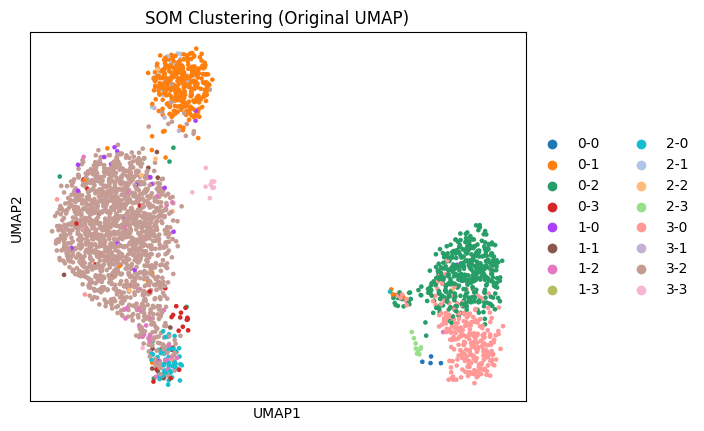

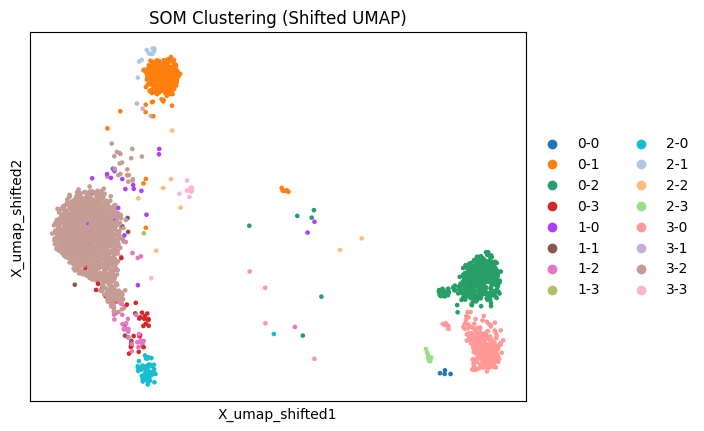

In [27]:
from minisom import MiniSom
from sklearn.metrics import silhouette_score
import numpy as np
import scanpy as sc

# 1. SOM clustering with hyperparameter tuning
som_size = 4  # 4x4 grid -> 16 clusters
encoding_dim = latent_X.shape[1]

best_score = -1
best_params = None

# Grid search over sigma and learning_rate
for sigma in [0.5, 1.0, 1.5]:
    for lr in [0.3, 0.5, 0.7]:
        som = MiniSom(som_size, som_size, encoding_dim, sigma=sigma, learning_rate=lr)
        som.random_weights_init(latent_X)
        som.train_random(latent_X, 1000, verbose=False)
        win_map = np.array([som.winner(x) for x in latent_X])
        cluster_ids = [i * som_size + j for i, j in win_map]
        score = silhouette_score(latent_X, cluster_ids)
        print(f"SOM: sigma={sigma}, lr={lr}, Silhouette={score:.3f}")
        if score > best_score:
            best_score = score
            best_params = (sigma, lr)

# 2. Retrain SOM using best parameters
som = MiniSom(som_size, som_size, encoding_dim, sigma=best_params[0], learning_rate=best_params[1])
som.random_weights_init(latent_X)
som.train_random(latent_X, 1000, verbose=True)

win_map = np.array([som.winner(x) for x in latent_X])
clusters = [f"{i}-{j}" for i, j in win_map]
cluster_ids = [i * som_size + j for i, j in win_map]

adata.obs['som_cluster'] = clusters
adata.obs['som_cluster_id'] = cluster_ids

# 3. UMAP computation on latent space
sc.pp.neighbors(adata, use_rep='X_latent', n_neighbors=15)
sc.tl.umap(adata)

# 4. Shift UMAP coordinates to reduce overlap
umap_coords = adata.obsm["X_umap"].copy()
clusters = adata.obs["som_cluster"]
shifted_umap = umap_coords.copy()

for cluster in np.unique(clusters):
    cluster_indices = clusters == cluster
    cluster_points = umap_coords[cluster_indices]
    
    centroid = np.mean(cluster_points, axis=0)
    direction_to_centroid = centroid - cluster_points
    
    # Shift 20% toward centroid
    shifted_umap[cluster_indices] += .5 * direction_to_centroid

# Save shifted coordinates in AnnData object
adata.obsm["X_umap_shifted"] = shifted_umap

# 5. Visualize UMAPs
sc.pl.umap(adata, color=['som_cluster'], title="SOM Clustering (Original UMAP)", save='_som_umap.png')
sc.pl.embedding(adata, basis="X_umap_shifted", color='som_cluster', title="SOM Clustering (Shifted UMAP)", save='_som_umap_shifted.png')



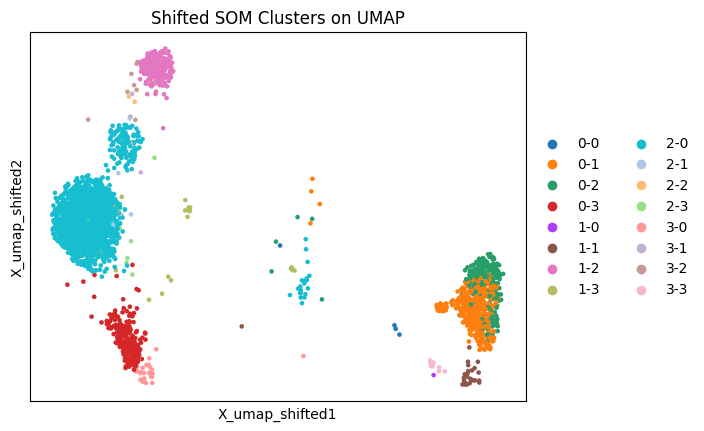

In [25]:
# Visualize the shifted UMAP
sc.pl.embedding(adata, basis="X_umap_shifted", color='som_cluster',
                title="Shifted SOM Clusters on UMAP", save='_som_umap_shifted.png')


# Generate UMAP visualizations for the clustering results.

- Computes the neighborhood graph on the latent space.
- Computes the UMAP embedding.
- Generates and saves UMAP plots colored by various clustering results: SOM clusters, KMeans clusters, Leiden clusters (from PCA), and Louvain clusters.

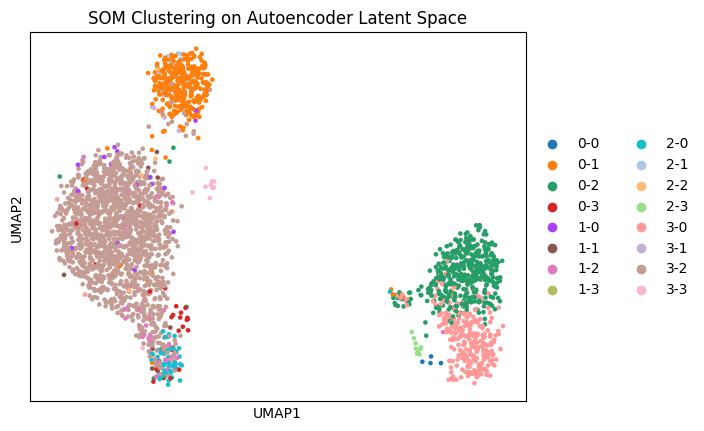

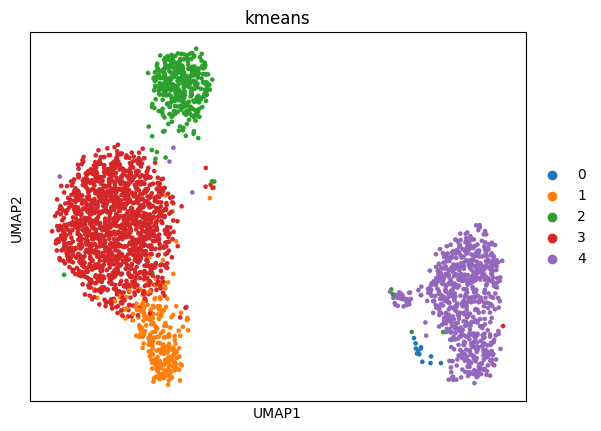

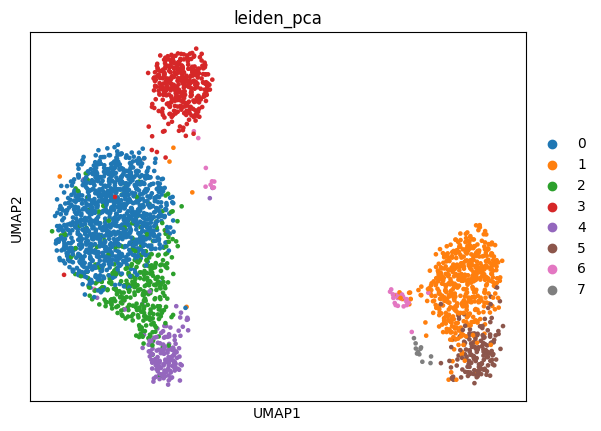

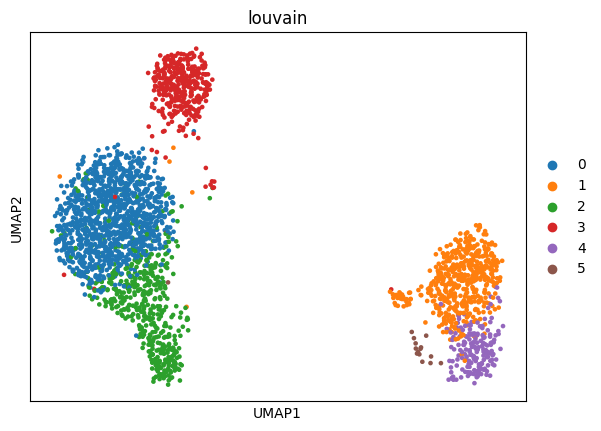

In [28]:
# Generate UMAP plots
sc.pp.neighbors(adata, use_rep='X_latent', n_neighbors=15)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['som_cluster'], title="SOM Clustering on Autoencoder Latent Space", save='_som_umap.png')
sc.pl.umap(adata, color=['kmeans'], save='_kmeans_umap.png')
sc.pl.umap(adata, color=['leiden_pca'], save='_pca_leiden_umap.png')
sc.pl.umap(adata, color=['louvain'], save='_louvain_umap.png')